# Can we predict the temperature given humidity, pressure and wind speed?

### Load packages and prepare the data.

Our data was extracted and prepared in a different notebook (thank you Josie!) but we will present the data analysis in this talk.

### Data preparation

- Local (single grid point) and regional (averaged over a 50 x 50 grid) data over the UK. 
- Considered a single point in time (0000Z)
- Realizations were 6 hours on from initialization.
- Ensembles were split into 8 training sets, which were then averaged, and 4 test sets.
- Only the 4 variables of interest were extracted due to storage constraints.


In [5]:
import os
os.getcwd()

from matplotlib import pyplot as plt
import numpy as np
import netCDF4
import pandas as pd
import scipy.stats as stats


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import neural_network
from sklearn import svm


In [6]:
#Read in the data.
data_set = netCDF4.Dataset('ensemble_means_201401_lat250_lon100.nc')
data_setFeb = netCDF4.Dataset('ensemble_means_201402_lat250_lon100.nc')
data_setMar = netCDF4.Dataset('ensemble_means_201403_lat250_lon100.nc')
data_settestJan = netCDF4.Dataset('test_data_201401_lat250_lon100.nc')
data_settestFeb = netCDF4.Dataset('test_data_201402_lat250_lon100.nc')
data_settestMar = netCDF4.Dataset('test_data_201403_lat250_lon100.nc')

data_set_regional = netCDF4.Dataset('ensemble_regional_means_201401.nc')
data_set_regional_test = netCDF4.Dataset('regional_test_data_201401.nc')
data_set_regional_Feb = netCDF4.Dataset('ensemble_regional_means_201402.nc')
data_set_regional_test_Feb = netCDF4.Dataset('regional_test_data_201402.nc')

In [7]:
#Prepare the data.

temperatureJan = data_set.variables['Temperature']
pressureJan = data_set.variables['Pressure']
humidityJan = data_set.variables['Humidity']
windspeedJan = data_set.variables['Wind Speed']

temperatureFeb = data_setFeb.variables['Temperature']
pressureFeb = data_setFeb.variables['Pressure']
humidityFeb = data_setFeb.variables['Humidity']
windspeedFeb = data_setFeb.variables['Wind Speed']

temperatureMar = data_setMar.variables['Temperature']
pressureMar = data_setMar.variables['Pressure']
humidityMar = data_setMar.variables['Humidity']
windspeedMar = data_setMar.variables['Wind Speed']

temptestJan = data_settestJan.variables['Temperature']
pressuretestJan = data_settestJan.variables['Pressure']
humiditytestJan = data_settestJan.variables['Humidity']
windspeedtestJan = data_settestJan.variables['Wind Speed']

temptestFeb = data_settestFeb.variables['Temperature']
pressuretestFeb = data_settestFeb.variables['Pressure']
humiditytestFeb = data_settestFeb.variables['Humidity']
windspeedtestFeb = data_settestFeb.variables['Wind Speed']

temptestMar = data_settestMar.variables['Temperature']
pressuretestMar = data_settestMar.variables['Pressure']
humiditytestMar = data_settestMar.variables['Humidity']
windspeedtestMar = data_settestMar.variables['Wind Speed']

temptestregJan = data_set_regional_test.variables['Temperature']
pressuretestregJan = data_set_regional_test.variables['Pressure']
humiditytestregJan = data_set_regional_test.variables['Humidity']
windtestregJan = data_set_regional_test.variables['Wind Speed']


temperatureregJan = data_set_regional.variables['Temperature']
pressureregJan = data_set_regional.variables['Pressure']
humidityregJan = data_set_regional.variables['Humidity']
windregJan = data_set_regional.variables['Wind Speed']

temptestregFeb = data_set_regional_test_Feb.variables['Temperature']
pressuretestregFeb = data_set_regional_test_Feb.variables['Pressure']
humiditytestregFeb = data_set_regional_test_Feb.variables['Humidity']
windtestregFeb = data_set_regional_test_Feb.variables['Wind Speed']


temperatureregFeb = data_set_regional_Feb.variables['Temperature']
pressureregFeb = data_set_regional_Feb.variables['Pressure']
humidityregFeb = data_set_regional_Feb.variables['Humidity']
windregFeb = data_set_regional_Feb.variables['Wind Speed']


In [8]:
temperature_train = np.concatenate([temperatureJan,temperatureFeb,temperatureMar])
pressure_train = np.concatenate([pressureJan,pressureFeb,pressureMar])
humidity_train = np.concatenate([humidityJan,humidityFeb,humidityMar])
wind_train = np.concatenate([windspeedJan,windspeedFeb,windspeedMar])

temperature_test = np.concatenate([np.mean(temptestJan,axis=1),np.mean(temptestFeb,axis=1),np.mean(temptestMar,axis=1)])
pressure_test = np.concatenate([np.mean(pressuretestJan,axis=1),np.mean(pressuretestFeb,axis=1),np.mean(pressuretestMar,axis=1)])
humidity_test = np.concatenate([np.mean(humiditytestJan,axis=1),np.mean(humiditytestFeb,axis=1),np.mean(humiditytestMar,axis=1)])
wind_test = np.concatenate([np.mean(windspeedtestJan,axis=1),np.mean(windspeedtestFeb,axis=1),np.mean(windspeedtestMar,axis=1)])

### Take a look at the data.

In [9]:
d={'humidity': humidity_train, 'pressure': pressure_train, 'wind speed': wind_train, 'temperature': temperature_train}
df = pd.DataFrame(data=d)
df.describe()

,humidity,pressure,wind speed,temperature
count,90.000000,90.000000,90.000000,90.000000
mean,49.287327,98685.046875,21.006618,246.361465
std,23.258949,1635.004761,9.489544,5.351416
min,2.343750,94951.375000,4.677218,236.578125
25%,31.718750,97611.878906,14.701131,241.980469
50%,52.578125,98805.914062,20.392796,245.335938
75%,67.554688,99652.421875,27.560231,251.222656
max,87.078125,102243.562500,46.334248,258.500000


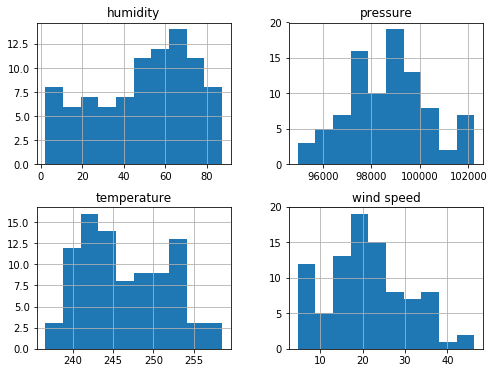

In [10]:
df.hist(figsize=(8,6))
plt.show()

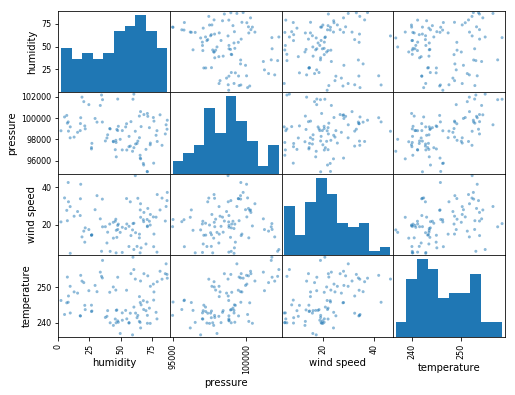

In [11]:
from pandas.plotting import scatter_matrix
scatter_matrix(df,figsize=(8,6))
plt.show()

### Linear regression.

In [12]:
predictors_train=np.stack((humidity_train,pressure_train,wind_train),axis=1)
predictors_test=np.stack((humidity_test,pressure_test,wind_test),axis=1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(predictors_train,temperature_train)

# Make predictions using the testing set
temperature_pred = regr.predict(predictors_test)

# The coefficients.
print('Coefficients: \n', regr.coef_)
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(temperature_test, temperature_pred))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(temperature_test, temperature_pred))



Coefficients: 
 [0.04897484 0.00189851 0.18523741]
Mean squared error: 15.16
Variance score: 0.46


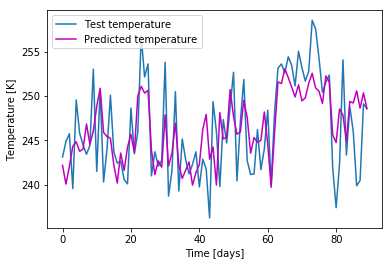

In [13]:
plt.plot(temperature_test,label='Test temperature')
plt.plot(temperature_pred,'m',label='Predicted temperature')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Temperature [K]')
plt.show()

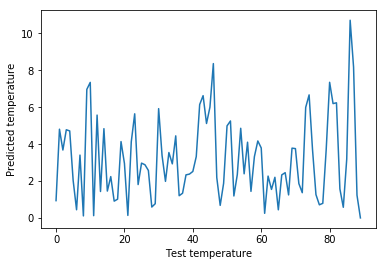

In [14]:
plt.plot(np.sqrt((temperature_test-temperature_pred)**2))
plt.xlabel('Test temperature')
plt.ylabel('Predicted temperature')
plt.show()

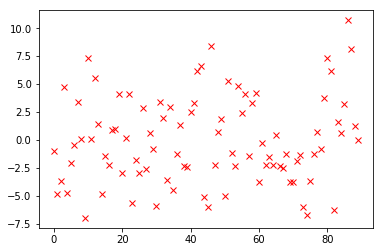

In [15]:
plt.plot(temperature_pred - temperature_test,'rx')
plt.show()

### Multi-layer regression.

In [16]:
#MLPRegressor

# Create multilevel regression object.
regrML = neural_network.MLPRegressor(solver='lbfgs')

# Train the model using the training sets.
regrML.fit(predictors_train,temperature_train)

# Make predictions using the testing set.
temperature_predML = regrML.predict(predictors_test)


In [17]:
# The coefficients.
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(temperature_test, temperature_predML))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(temperature_test, temperature_predML))

#print(regrML.n_iter_)
print('Number of layers: %.2f' % regrML.n_layers_)

Mean squared error: 15.88
Variance score: 0.44
Number of layers: 3.00


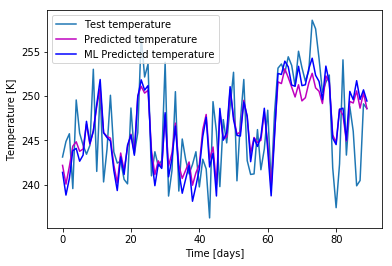

In [18]:
plt.plot(temperature_test,label='Test temperature')
plt.plot(temperature_pred,'m',label='Predicted temperature')
plt.plot(temperature_predML,'b',label='ML Predicted temperature')
plt.xlabel('Time [days]')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()

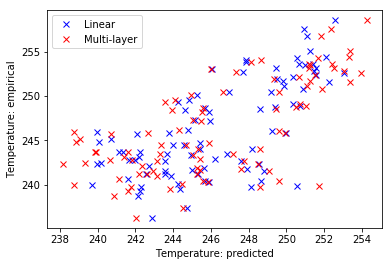

In [19]:
plt.plot(temperature_pred, temperature_test,'bx',label='Linear')
plt.plot(temperature_predML, temperature_test,'rx',label='Multi-layer')
plt.xlabel('Temperature: predicted')
plt.ylabel('Temperature: empirical')
plt.legend()
plt.show()

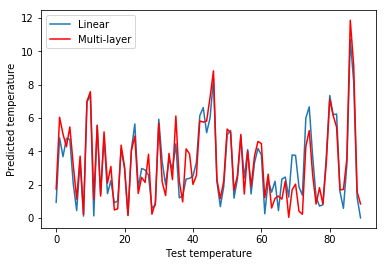

In [20]:
plt.plot(np.sqrt((temperature_test-temperature_pred)**2),label='Linear')
plt.plot(np.sqrt((temperature_test-temperature_predML)**2),'r',label='Multi-layer')
plt.xlabel('Test temperature')
plt.ylabel('Predicted temperature')
plt.legend()
plt.show()

## How does machine learning compare to persistance?

Both machine learning experiments result in quite high RMS values. We wish to see if the skill of either our linear regression or three layer neural network beat persistence. We will use temperatures from the previous day to test this.

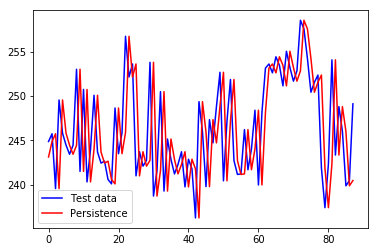

In [21]:
plt.plot(temperature_test[1:89],'b',label='Test data')
plt.plot(temperature_test[0:88],'r',label='Persistence')
plt.legend()
plt.show()

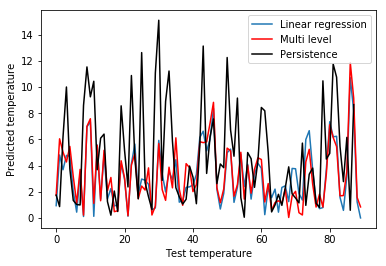

In [22]:
# Plot to show square root error of each estimate
plt.plot(np.sqrt((temperature_test-temperature_pred)**2),label='Linear regression')
plt.plot(np.sqrt((temperature_test-temperature_predML)**2),'r',label='Multi level')
plt.plot(np.sqrt((temperature_test[1:89]-temperature_test[0:88])**2),'k',label='Persistence')

plt.xlabel('Test temperature')
plt.ylabel('Predicted temperature')
plt.legend()
plt.show()

In [23]:
#np.sum((((temperature_test[1:89]-temperature_pred[1:89])/(temperature_test[1:89]-temperature_test[0:88]))**2)>1)
linbeatpers = np.sum((((temperature_test[1:89]-temperature_pred[1:89])/(temperature_test[1:89]-temperature_test[0:88]))**2)<1)

Linear model beats persistence for 54 out of 89 days.

In [24]:
#np.sum((((temperature_test[1:89]-temperature_pred[1:89])/(temperature_test[1:89]-temperature_test[0:88]))**2)>1)
mlbeatpers = np.sum((((temperature_test[1:89]-temperature_predML[1:89])/(temperature_test[1:89]-temperature_test[0:88]))**2)<1)

Multi-layer neural network beats persistence for {{mlbeatpers}} out of 89 days.

## Will our predictions improve if we normalise the variables? 



In [25]:
#functions to normalise and denormalise the variables
def normalize(value, min, max):
    normalized = (value - min) / (max - min);
    return normalized;

def denormalize(normalized, min, max):
    denormalized = (normalized * (max - min) + min);
    return denormalized;

In [26]:
## Normalise the data sets 

norm_temperature_train = normalize(temperature_train,np.min(temperature_train),np.max(temperature_train))
norm_humidity_train = normalize(humidity_train,np.min(humidity_train),np.max(humidity_train))
norm_pressure_train = normalize(pressure_train,np.min(pressure_train),np.max(pressure_train))
norm_wind_train = normalize(wind_train,np.min(wind_train),np.max(wind_train))

norm_temperature_test = normalize(temperature_test,np.min(temperature_test),np.max(temperature_test))
norm_humidity_test = normalize(humidity_test,np.min(humidity_test),np.max(humidity_test))
norm_pressure_test = normalize(pressure_test,np.min(pressure_test),np.max(pressure_test))
norm_wind_test = normalize(wind_test,np.min(wind_test),np.max(wind_test))

#print(min(norm_temperature_train))

In [27]:
# Split the targets into training/testing sets.


norm_predictors_train=np.stack((norm_humidity_train,norm_pressure_train,norm_wind_train),axis=1)
norm_predictors_test=np.stack((norm_humidity_test,norm_pressure_test,norm_wind_test),axis=1)

# Create linear regression object
norm_regr = linear_model.LinearRegression()

# Train the model using the training sets
norm_regr.fit(norm_predictors_train,norm_temperature_train)

# Make predictions using the testing set
norm_temperature_pred = norm_regr.predict(norm_predictors_test)

# The coefficients.
print('Coefficients: \n', norm_regr.coef_)
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(norm_temperature_test, norm_temperature_pred))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(norm_temperature_test, norm_temperature_pred))


Coefficients: 
 [0.18930188 0.631528   0.35199735]
Mean squared error: 0.03
Variance score: 0.46


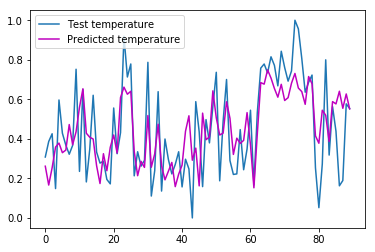

In [28]:
plt.plot(norm_temperature_test,label='Test temperature')
plt.plot(norm_temperature_pred,'m',label='Predicted temperature')
plt.legend()
plt.show()

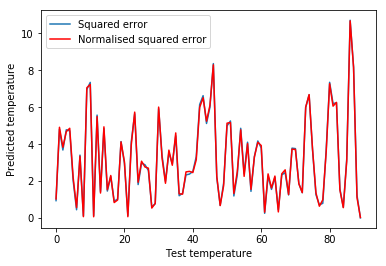

In [29]:
plt.plot(np.sqrt((temperature_test-temperature_pred)**2),label='Squared error')
plt.plot(np.sqrt((denormalize(norm_temperature_test,np.min(temperature_test),np.max(temperature_test))
                  -denormalize(norm_temperature_pred,np.min(temperature_test),np.max(temperature_test)))**2),\
         'r',label='Normalised squared error')
plt.xlabel('Test temperature')
plt.ylabel('Predicted temperature')
plt.legend()
plt.show()

### No, we get exactly the same output.

### Will our results be better if we use data that is smoothed?

Smoothing should remove some of the noise from our data and may make it easier for our regression/NN to obtain good results

In [30]:
humidityreg = np.concatenate([humidityregJan,humidityregFeb])
pressurereg = np.concatenate([pressureregJan,pressureregFeb])
temperaturereg = np.concatenate([temperatureregJan,temperatureregFeb])
windreg = np.concatenate([windregJan,windregFeb])

humiditytestreg = np.concatenate([humiditytestregJan,humiditytestregFeb])
pressuretestreg = np.concatenate([pressuretestregJan,pressuretestregFeb])
temperaturetestreg = np.concatenate([temptestregJan,temptestregFeb])
windtestreg = np.concatenate([windtestregJan,windtestregFeb])

In [31]:
predictors_train_sm=np.stack((humidityreg,pressurereg,windreg),axis=1)
predictors_test_sm=np.stack((np.mean(humiditytestreg,axis=1),np.mean(pressuretestreg,axis=1),np.mean(windtestreg,axis=1)),axis=1)

# Create linear regression object
regr_sm = linear_model.LinearRegression()

# Train the model using the training sets
regr_sm.fit(predictors_train_sm,temperaturereg)

# Make predictions using the testing set
temperature_pred_sm = regr_sm.predict(predictors_test_sm)

# The coefficients.
print('Coefficients: \n', regr_sm.coef_)
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(temperaturereg, temperature_pred_sm))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(temperaturereg, temperature_pred_sm))


Coefficients: 
 [0.05169106 0.00101268 0.22159222]
Mean squared error: 11.23
Variance score: 0.35


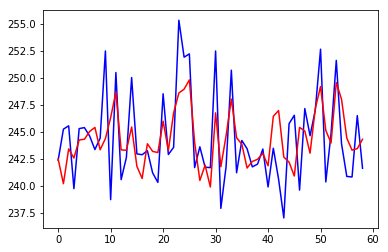

In [32]:
plt.plot(np.mean(temperaturetestreg,axis=1),'b')
plt.plot(temperature_pred_sm,'r')
plt.show()

In [33]:
np.corrcoef(np.mean(temperaturetestreg,axis=1),temperature_pred_sm)

array([[1.        , 0.59586989],
       [0.59586989, 1.        ]])

In [34]:
np.corrcoef(temperature_test,temperature_pred)

array([[1.        , 0.67999851],
       [0.67999851, 1.        ]])

In [35]:
meantemptest = np.mean(temperaturetestreg,axis=1)

print(np.corrcoef(meantemptest[0:29],meantemptest[1:30]))

[[ 1.         -0.02219558]
 [-0.02219558  1.        ]]


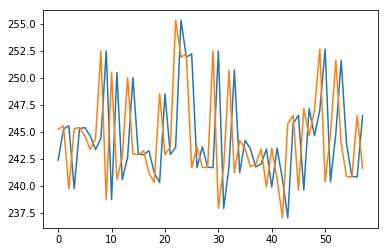

In [36]:
plt.plot(meantemptest[0:58])
plt.plot(meantemptest[1:59])
plt.show()

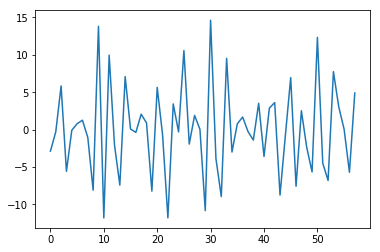

In [37]:
plt.plot(meantemptest[0:58]-meantemptest[1:59])
plt.show()

### Multi level on smoothed data

In [38]:
#MLPRegressor

# Create multilevel regression object
regrML_sm = neural_network.MLPRegressor(solver='lbfgs')

# Train the model using the training sets
regrML_sm.fit(predictors_train_sm,temperaturereg)

# Make predictions using the testing set
temperature_predML_sm = regrML_sm.predict(predictors_test_sm)

In [39]:
# The coefficients.
#print('Coefficients: \n', regrML.coefs_)
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(temperaturereg, temperature_predML_sm))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(temperaturereg, temperature_predML_sm))

#print(regrML.intercepts_)
print(regrML_sm.n_iter_)
#intercepts_
print('Number of layers: %.2f' % regrML_sm.n_layers_)

Mean squared error: 13.97
Variance score: 0.20
94
Number of layers: 3.00


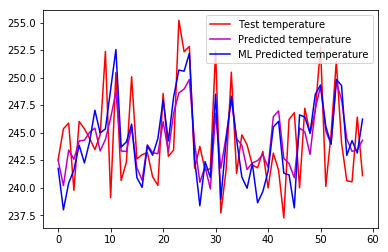

In [40]:
plt.plot(temperaturereg,'r',label='Test temperature')
plt.plot(temperature_pred_sm,'m',label='Predicted temperature')
plt.plot(temperature_predML_sm,'b',label='ML Predicted temperature')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(temperaturereg,temperature_pred_sm))
rms

3.350686410071843

In [42]:
rmsML = sqrt(mean_squared_error(temperaturereg,temperature_predML_sm))
rmsML

3.7372739022707164

In [43]:
rmsper = sqrt(mean_squared_error(temperaturereg[0:58],temperaturereg[1:59]))
rmsper

6.166047486158576

### Smoothed data and a different time

In [44]:
data_set_regional_t3 = netCDF4.Dataset('ensemble_regional_means_201401_t3.nc')
data_set_regional_test_t3 = netCDF4.Dataset('regional_test_data_201401_t3.nc')

temptestreg_t3 = data_set_regional_test_t3.variables['Temperature']
pressuretestreg_t3 = data_set_regional_test_t3.variables['Pressure']
humiditytestreg_t3 = data_set_regional_test_t3.variables['Humidity']
windtestreg_t3 = data_set_regional_test_t3.variables['Wind Speed']


temperaturereg_t3 = data_set_regional_t3.variables['Temperature']
pressurereg_t3 = data_set_regional_t3.variables['Pressure']
humidityreg_t3 = data_set_regional_t3.variables['Humidity']
windreg_t3 = data_set_regional_t3.variables['Wind Speed']

In [45]:
#MLPRegressor
predictors_train_sm_t3=np.stack((humidityreg_t3,pressurereg_t3,windreg_t3),axis=1)
predictors_test_sm_t3=np.stack((np.mean(humiditytestreg_t3,axis=1),np.mean(pressuretestreg_t3,axis=1),np.mean(windtestreg_t3,axis=1)),axis=1)


# Create linear regression object
regr_sm_t3 = linear_model.LinearRegression()

# Train the model using the training sets
regr_sm_t3.fit(predictors_train_sm_t3,temperaturereg_t3)

# Make predictions using the testing set
temperature_pred_sm_t3 = regr_sm_t3.predict(predictors_test_sm_t3)

# The coefficients.
print('Coefficients: \n', regr_sm_t3.coef_)
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(temperaturereg_t3, temperature_pred_sm_t3))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(temperaturereg_t3, temperature_pred_sm_t3))


Coefficients: 
 [0.07867002 0.00102359 0.19508927]
Mean squared error: 13.98
Variance score: 0.36


In [46]:
# Create multilevel regression object
regrML_sm_t3 = neural_network.MLPRegressor(solver='lbfgs')

# Train the model using the training sets
regrML_sm_t3.fit(predictors_train_sm_t3,temperaturereg_t3)

# Make predictions using the testing set
temperature_predML_sm_t3 = regrML_sm_t3.predict(predictors_test_sm_t3)

In [47]:
# The coefficients.
#print('Coefficients: \n', regrML.coefs_)
# The mean squared error.
print("Mean squared error: %.2f"
      % mean_squared_error(temperaturereg_t3, temperature_predML_sm_t3))
# Explained variance score: 1 is perfect prediction.
print('Variance score: %.2f' % r2_score(temperaturereg_t3, temperature_predML_sm_t3))

#print(regrML.intercepts_)
print(regrML_sm_t3.n_iter_)
#intercepts_
print('Number of layers: %.2f' % regrML_sm_t3.n_layers_)

Mean squared error: 16.14
Variance score: 0.26
61
Number of layers: 3.00


In [48]:
rmsML_t3 = sqrt(mean_squared_error(temperaturereg_t3,temperature_predML_sm_t3))
rmsML_t3

4.0170155395555085

# Conclusions

- Linear regression is not a suitable method to predict temperature using this humidity, pressure and wind speed data.
- A more sophisticated neural network also failed to produce good results
- This is likely due to a poor choice of predictors.
- Smoothing the data spatially improved the RMS error slightly. This is probably due to a reduction in noise.
- However, we did beat persistence around 60% of the time!